- In this notebook ideas of Simon Funk's SVD approach are used to fit two feature matrices on a given utility matrix. The feature matrices correspond to latent movie features and latent user features. Based on the matrix multiplication of the feature matrices the utility matrix is approximated. The fitted feature matrices are then used to make predictions for a separate test set. 

- The movie & rating data is based on the MovieLens 100K (09/2018) data set

In [1]:
import numpy as np
import pandas as pd
import numpy.ma as ma 
from utility_matrix_prep import create_utility_matrix, get_merged_ratings_df

import matplotlib.pyplot as plt

### Load data

In [2]:
#load ratings data:
path = '/media/vincent/harddrive/Movielens_data/ml-small_09_2018/'
file_name = 'ratings.csv'

rating_data = pd.read_csv(path + file_name,  encoding = "ISO-8859-1", header=0)

#load movies data:
movies_data = pd.read_csv(path + 'movies.csv',encoding = "ISO-8859-1", header=0)
#adjust some col-labels:
movies_data['movie_title'] = movies_data['title']
movies_data = movies_data[['movieId','movie_title','genres']]
    


### Train & Test split

The data set is sorted by the given timestamps. The most recent ratings of each user are used as test set (most recent 20%). The remaining ratings make up the training set.

In [3]:
def train_test_split(data_df, ratio = 0.2):
    
    '''
    creates test_set based on most recent x% of ratings for each user 
    remaining entries are used as training set
    '''
    
    test_set = pd.DataFrame(columns=data_df.columns)
    train_set = pd.DataFrame(columns=data_df.columns)

    grouped_ratings = data_df.groupby('userId')
    
    #get most recent ratings of each user and split into train & testset:
    for name, group in grouped_ratings:
        set_size = int(group.shape[0] * ratio)
        temp_test = group.sort_values('timestamp').iloc[group.shape[0]-1-set_size:] #slice last (most recent) rows of sorted df
        temp_train = group.sort_values('timestamp').iloc[:group.shape[0]-2-set_size] #slice first rows of sorted df
        
        test_set = pd.concat([test_set, temp_test])
        train_set = pd.concat([train_set, temp_train])
        
    return train_set, test_set

In [4]:
#split data:
train_ratings, test_ratings = train_test_split(rating_data, ratio = 0.2)
print('shape of train_ratings: ', train_ratings.shape)
print('shape of test_ratings: ', test_ratings.shape)

# prepare test_set:
print('\n test set before processing: \n  \n', test_ratings.head(2))
#call custom function:
test_ratings = get_merged_ratings_df(test_ratings,movies_data)
test_ratings['userId'] = test_ratings['userId'].apply(lambda row: 'User_' + str(row))
print('\n test set after processing: \n  \n', test_ratings.head(2))



shape of train_ratings:  (79676, 4)
shape of test_ratings:  (20550, 4)

 test set before processing: 
  
     userId movieId  rating  timestamp
192      1    2959     5.0  964983282
176      1    2654     5.0  964983393

 test set after processing: 
  
    userId           movie_title  rating
0  User_1     Fight Club (1999)     5.0
1  User_1  Wolf Man, The (1941)     5.0


### Create Utility Matrix

Based on the training set, the utility matrix is created which contains the ratings for each user as a row entry. Columns indicate the different movie titles.

In [5]:
#call custom function to create utility matrix
train_utilmatrix = create_utility_matrix(ratings_df = train_ratings, movies_df = movies_data)
print('shape of utility matrix: ', train_utilmatrix.shape)

#get glimpse on utility matrix:
train_utilmatrix.iloc[0:5,:10]

No. of duplicated entries:  0
shape of utility matrix:  (610, 9737)


,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995)
User_1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN
User_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cost function & Update rule

Based on the approach of Simon Funk, a function is defined to fit two feature matrices ("latent_users" & "latent_movies") which are learned to predict the actual user ratings through matrix multiplication. Batch Gradient Descent is used to train the feature matrices. Since the idea is inspired by the SVD technique, it is known as "Funk SVD".

**Parameters to define**:

- alpha learning rate
- regularization term
- number of training iterations
- dimensions of feature matrices

**addtional parameters**:

- normalize utility matrix by subtracting average movie ratings
- "baseline" flag adds the mean movie rating and the average user's offset
*(the offset is defined as "average offset between a user's rating and the movie's average rating, for every user")*


**Note**: So far, I couldn't find a combination of the additional parameters that beats the result of a "simple" Batch Gradient Descent training 

In [6]:
def batch_GD_fsvd(util_matrix = None, latent_users = None, latent_movies = None, 
                                alpha = 0.00001, regul = 0.00001, n_iter=100, 
                                mean_normalize = False, baseline = False, verbose=0):
    
    
    # the nan or unavailable entries are masked
    mask = np.isnan(util_matrix)
    #create masked array:
    util_masked = np.ma.masked_array(util_matrix, mask)
    
    #calculate mean without considering the NaN values:
    movie_means = np.mean(util_masked, axis=0)
    
    #as suggested by Simon Funk calcualte user offset:
    offset = util_masked - movie_means
    avg_offset = np.mean(offset, axis=1)
    avg_offset = np.reshape(avg_offset, (-1,1))
    
               
    #fill NaN values with "0" --> through matrix multiplication "0" values do not contribute to loss & gradient
    util_masked = util_masked.filled(0)
    
    if mean_normalize == True:

        #apply mean normalization:
        util_masked = util_masked - movie_means
    
    
    #create list to store loss information
    loss_list = []

    for i in range(n_iter):
        
        if baseline == True and mean_normalize == False:
            preds = np.dot(latent_users, latent_movies) + movie_means + avg_offset

        else:
            preds = np.dot(latent_users, latent_movies) 
          
        #apply mask again to only consider predictions for which we have actual values given in training set
        preds_mask = np.ma.array(preds, mask=mask)
        #fill NaNs with 0 --> through matrix multiplication "0" values do not contribute to loss & gradient
        preds = preds_mask.filled(0)
        
        #calculate error:
        error_matrix = preds - util_masked
                
        loss = (1/2) * np.sum(error_matrix**2) + (regul/2) * np.sum(latent_users**2) + (regul/2) * np.sum(latent_movies**2)
        mse_error = np.sum(error_matrix**2)/util_masked.shape[0]
        
        #store result:
        loss_list.append([loss,mse_error,i])
        
        if verbose > 0:
            print('Iteration ', i)
            print('Current loss: ', loss , ' \n')
        
        if verbose > 1:
            print('Latent User features sample: \n', latent_users[0:5,:5])
        
        #update latent_user features:
        latent_users = latent_users - alpha*(np.dot(error_matrix,latent_movies.transpose()) + regul*latent_users)
        
        #update latent movie features:
        latent_movies = latent_movies - alpha*(np.dot(latent_users.transpose(),error_matrix) + regul*latent_movies)
        
        
    #return non-masked matrices & training information:  
    return np.ma.getdata(latent_users), np.ma.getdata(latent_movies), np.ma.getdata(movie_means), np.ma.getdata(avg_offset), np.array(loss_list)

### Fit model

The dimension of the feature matrices are defined and the matrices are initialized randomly 

In [7]:
#initialize latent features randomly:

dim = 20
util_size_rows = train_utilmatrix.shape[0]
util_size_cols = train_utilmatrix.shape[1]

np.random.seed(123)

latent_user_feat = np.random.random((util_size_rows,dim))
latent_movies_feat = np.random.random((dim,util_size_cols))


#define the training parameter alpha and the regularization parameter and fit the feature matrices:
learned_lat_users, learned_lat_movies, item_means, user_offset, loss_info = batch_GD_fsvd(util_matrix = train_utilmatrix, 
                                                                            latent_users = latent_user_feat,
                                                                            latent_movies = latent_movies_feat,
                                                                            alpha = 0.00001, regul = 0.00001,
                                                                            n_iter=150, mean_normalize = False,
                                                                            baseline = False, verbose = 1)



Iteration  0
Current loss:  154064.69070145383  

Iteration  1
Current loss:  147765.15378887896  

Iteration  2
Current loss:  142192.8002392737  

Iteration  3
Current loss:  137231.48798988317  

Iteration  4
Current loss:  132786.40132785361  

Iteration  5
Current loss:  128779.88118870601  

Iteration  6
Current loss:  125148.09829086057  

Iteration  7
Current loss:  121838.39480176593  

Iteration  8
Current loss:  118807.15703216897  

Iteration  9
Current loss:  116018.11050560385  

Iteration  10
Current loss:  113440.95141768902  

Iteration  11
Current loss:  111050.24634391088  

Iteration  12
Current loss:  108824.54612586435  

Iteration  13
Current loss:  106745.6709792734  

Iteration  14
Current loss:  104798.13265666379  

Iteration  15
Current loss:  102968.66645815058  

Iteration  16
Current loss:  101245.85140261687  

Iteration  17
Current loss:  99619.80125211364  

Iteration  18
Current loss:  98081.9125631001  

Iteration  19
Current loss:  96624.65870676373

#### plot training curve 

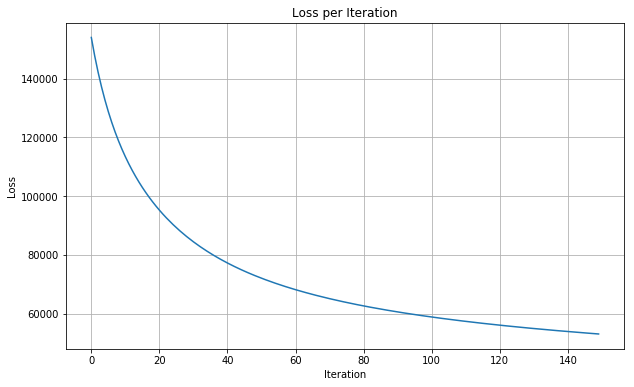

In [8]:
fig, ax = plt.subplots(figsize=(10,6)) 
ax.plot(loss_info[:,2],loss_info[:,0])
ax.set(xlabel='Iteration', ylabel='Loss',
       title='Loss per Iteration')
ax.grid()
plt.show()


### Evaluation

Functions to get predictions for test set & calculate RMSE

In [10]:
def get_preds(user_feat = None, movie_feat= None, item_means= None, offset_values= None, 
              mean_normalize = False, baseline = False, clipping = False, clip_thresholds = [0,5]):
    
    '''
    returns the predictions based on learned feature vectors and additional predictors
    
    clipping: sets the predictions into the given range between
    '''
    
    if baseline == True and mean_normalize == False:
        prediction_matrix = np.dot(user_feat, movie_feat) + item_means + offset_values
            
    elif mean_normalize == True and baseline == False:
        prediction_matrix = np.dot(user_feat, movie_feat) + item_means 
        
    else:
        prediction_matrix = np.dot(user_feat, movie_feat) 
        
    if clipping == True:
        prediction_matrix = prediction_matrix.clip(clip_thresholds[0], clip_thresholds[1])
        
    return prediction_matrix
    
    


def lookup_preds(row, util_matrix = None):
    
    '''function looks up values in util_matrix
        if there is no match since the movie does not have entries in the util_matrix,
        return the mean rating of the user's existing ratings
    '''
    
    #slice correct user_id
    df_row_slice = util_matrix[util_matrix.index == row['userId']]
    
    #slice value of column match:
    try:
        df_col_val = df_row_slice.at[row['userId'],row['movie_title']]
    except:
        df_col_val = df_row_slice.mean(axis=1)
    
    return df_col_val



def rmse(df):
    diff_sqt = (df['rating'] - df['preds'])**2
    rmse = np.sqrt(diff_sqt.sum()/len(diff_sqt))
    print('RMSE: ', rmse)
    return rmse


#### Make predictions 

Based on fitted feature matrices make predictions

In [11]:
#get predictions (add item means if mean normalization was used for training or bias_flag was set)
final_preds =  get_preds(learned_lat_users, learned_lat_movies, item_means, user_offset, 
                         mean_normalize = False, baseline = False, clipping=True)

print('Shape of predictions: ', final_preds.shape)
print('Shape of utility matrix: ', train_utilmatrix.shape)

#add index & column labels & get glimpse on predictions:
movie_idx = train_utilmatrix.columns
users_idx = train_utilmatrix.index

preds_matrix_df = pd.DataFrame(final_preds, index=users_idx, columns=movie_idx)

print('\n Glimpse on predictions: \n {}'.format(preds_matrix_df.iloc[0:5,:2]))
print('\n Glimpse on true values: \n {}'.format(train_utilmatrix.iloc[0:5,:2]))

Shape of predictions:  (610, 9737)
Shape of utility matrix:  (610, 9737)

 Glimpse on predictions: 
         Toy Story (1995)  Jumanji (1995)
User_1          3.835453        4.111437
User_2          5.000000        4.925162
User_3          4.517374        4.450252
User_4          4.190534        4.049313
User_5          4.904408        4.539758

 Glimpse on true values: 
         Toy Story (1995)  Jumanji (1995)
User_1               4.0             NaN
User_2               NaN             NaN
User_3               NaN             NaN
User_4               NaN             NaN
User_5               4.0             NaN


For the data in the test set the corresponding predictions are looked up in the fitted matrix. If no predictions are available for a given movie title in the fitted matrix, the average rating of a user is used as prediction

In [12]:
# call function on each row to get predictions:
test_ratings['preds'] = test_ratings.apply(lambda x: lookup_preds(x, preds_matrix_df), axis=1)

print('\n', test_ratings.head(3), '\n')

#get rmse:
rmse_test = rmse(test_ratings)


    userId           movie_title  rating     preds
0  User_1     Fight Club (1999)     5.0  4.621698
1  User_1  Wolf Man, The (1941)     5.0  3.754667
2  User_1        Dracula (1931)     4.0  5.000000 

RMSE:  1.1838162882839798


#### Results of various other parameter combinations:

| n_iter | dim   |  alpha | regul | normalize | bias | clipping | TEST RMSE |
|------|------|------|------|------|------|------|------|
|   150  | 20| 0.00001  | 0.00001| -  | -| True  | 1.1838|
|   100  | 20| 0.00001  | 0.00001| -  | -| True  | 1.225|
|   150  | 20| 0.00001  | 0.00001| -  | -| -  | 1.2301|
|   100  | 20| 0.00001  | 0.00001| -  | -| -  | 1.2936|
|   150  | 30| 0.00001  | 0.00001| -  | -| -  | 1.5790|
|   150  | 30| 0.00001  | 0.00001| -  | -| True  | 1.2898|
|   150  | 20| 0.00001  | 0.00001| -  | True| -  | 2.1524|
|   150  | 20| 0.00001  | 0.00001| -  | True| True | 1.5297|
|   150  | 30| 0.00001  | 0.00001| -  | True| -  | 2.5173|
|   150  | 30| 0.00001  | 0.00001| -  | True| True | 1.5320|

